In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('train.csv')
#data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [3]:
data=data[:50]

In [4]:
data.isnull().sum()

id        0
title     0
author    7
text      0
label     0
dtype: int64

In [5]:
data.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

** We can see multiple null values here but for text type we can't impute the missing values so we will drop the missing values **

In [6]:
data=data.dropna()
data.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [7]:
messages=data.copy()

In [8]:
messages.reset_index(inplace=True,drop=True)

** I am resetting the index because some missing values are deleted so the entire row will be deleted so that index also get deleted ***

In [9]:
#!pip install nltk

In [10]:
#nltk.download('stopwords')

In [11]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

# Data processing

In [12]:
from nltk.corpus import brown
brown.words()

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:

ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)
    

In [15]:
corpus[1]

'flynn hillari clinton big woman campu breitbart'

In [16]:
import qiskit

In [17]:
## TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect=TfidfVectorizer()
X= vect.fit_transform(corpus).toarray()

In [18]:
X.shape

(43, 291)

In [19]:
y=messages['label']

In [20]:
y.shape

(43,)

## QSVM using IBM Qiskit

First we have createa first quantum circuit, with a classical register.



In [21]:
import qiskit as qk

# Creating Qubits
q = qk.QuantumRegister(2)
# Creating Classical Bits
c = qk.ClassicalRegister(2)

Create a empty circuit with 2 qubits and 2 registers

In [22]:
circuit = qk.QuantumCircuit(q, c)
print(circuit)


      
q0_0: 
      
q0_1: 
      
c0: 2/
      


In [23]:
# Initialize empty circuit
circuit = qk.QuantumCircuit(q, c)
# Hadamard Gate on the first Qubit
circuit.h(q[0])
# CNOT Gate on the first and second Qubits
circuit.cx(q[0], q[1])
# Measuring the Qubits
circuit.measure(q, c)
print (circuit)

      ┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0: 2/═══════════╩══╩═
                 0  1 


In [24]:
# Using Qiskit Aer's Qasm Simulator: Define where do you want to run the simulation.
simulator = qk.BasicAer.get_backend('qasm_simulator')

# Simulating the circuit using the simulator to get the result
job = qk.execute(circuit, simulator, shots=100)
result = job.result()

# Getting the aggregated binary outcomes of the circuit.
counts = result.get_counts(circuit)
print (counts)

{'11': 53, '00': 47}


In [25]:
#!pip install qiskit

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from qiskit import BasicAer,Aer
from qiskit.aqua.utils import split_dataset_to_data_and_labels,map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM

from qiskit.aqua.components.feature_maps import SecondOrderExpansion
import logging
from qiskit.aqua import set_qiskit_aqua_logging
from qiskit.aqua import aqua_globals
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from qiskit.aqua import aqua_globals


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [28]:
def data(training_size,test_size,n,plot_data=False):
    class_labels=["Not_Spam","Spam"]
    ## Divide the dataset into Train and Test
    data, target = X,y
    #print("This is data",data)
    #print("This is target",target)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=0.3, random_state=12)
    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    SVD = TruncatedSVD(n_components=n).fit(sample_train)
    sample_train = SVD.transform(sample_train)
    sample_test = SVD.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    if plot_data:
        for k in range(len(class_labels)):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("Spam dataset")
        plt.get_plot_commands()
        plt.show()
    return sample_train, training_input, test_input, class_labels

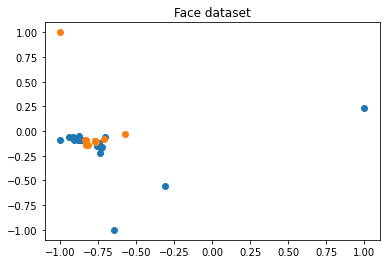

In [29]:
samples,training_input,test_input,class_labels=data(400,100,4,plot_data=True)

In [30]:
datapoints,class_to_label=split_dataset_to_data_and_labels(test_input)

In [31]:
get_feature_dimension(training_input)

4

In [34]:
seed = 10598

backend = BasicAer.get_backend('statevector_simulator')
feature_map = SecondOrderExpansion(feature_dimension=get_feature_dimension(training_input),
                                   depth=6, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input,  datapoints[0],
          multiclass_extension=AllPairs())
quantum_instance = QuantumInstance(backend, shots=1024,
                                    seed_simulator=seed,
                                    seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print("testing success ratio: {}".format(result['testing_accuracy']))
print("preduction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], qsvm.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

C:\Users\gunda\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The qiskit.aqua.components.feature_maps.SecondOrderExpansion object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.ZZFeatureMap instead.
  """
C:\Users\gunda\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\aqua\components\feature_maps\second_order_expansion.py:59: DeprecationWarning: The qiskit.aqua.components.feature_maps.PauliZExpansion class is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.PauliFeatureMap instead.
  z_order=2, data_map_func=data_map_func)
C:\Users\gunda\AppData\Local\Continuum\anaconda3\lib\site-packages\qiskit\aqua\components\feature_maps\pauli_z_expansion.py:71: DeprecationWarning: The qiskit.aqua.components.feature_maps.PauliExpansion object is deprecated as of 0.7.0 and will be removed 

testing success ratio: 0.9230769230769231
preduction of datapoints:
ground truth: ['Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Spam', 'Spam', 'Spam', 'Spam']
prediction:   ['Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Not_Spam', 'Spam', 'Spam', 'Spam', 'Spam', 'Spam']


In [33]:
qc = qsvm.construct_circuit(x1=datapoints[0][0], x2=datapoints[0][2]) # these are two data points.
qc.draw()

┌──────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
q_0: ┤ U2(0,pi) ├┤0             ├┤0             ├┤0             ├»
     ├──────────┤│              ││              ││              │»
q_1: ┤ U2(0,pi) ├┤1             ├┤1             ├┤1             ├»
     ├──────────┤│  Evolution^1 ││  Evolution^1 ││  Evolution^1 │»
q_2: ┤ U2(0,pi) ├┤2             ├┤2             ├┤2             ├»
     ├──────────┤│              ││              ││              │»
q_3: ┤ U2(0,pi) ├┤3             ├┤3             ├┤3             ├»
     └──────────┘└──────────────┘└──────────────┘└──────────────┘»
c: 4/════════════════════════════════════════════════════════════»
                                                                 »
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_0: ┤0             ├┤0             ├┤0             ├┤0             ├»
«     │              ││              ││              ││              │»
«q_1: ┤1             ├┤1             ├┤1             ├┤1             ├»
«     │  Evolution^1 ││  Evolution^1 ││  Evolution^1 ││  Evolution^1 │»
«q_2: ┤2             ├┤2             ├┤2             ├┤2             ├»
«     │              ││              ││              ││              │»
«q_3: ┤3             ├┤3             ├┤3             ├┤3             ├»
«     └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«c: 4/════════════════════════════════════════════════════════════════»
«                                                                     »
«     ┌──────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U2(0,pi) ├┤0             ├┤0             ├┤0             ├»
«     ├──────────┤│              ││              ││              │»
«q_1: ┤ U2(0,pi) ├┤1             ├┤1             ├┤1             ├»
«     ├──────────┤│  Evolution^1 ││  Evolution^1 ││  Evolution^1 │»
«q_2: ┤ U2(0,pi) ├┤2             ├┤2             ├┤2             ├»
«     ├──────────┤│              ││              ││              │»
«q_3: ┤ U2(0,pi) ├┤3             ├┤3             ├┤3             ├»
«     └──────────┘└──────────────┘└──────────────┘└──────────────┘»
«c: 4/════════════════════════════════════════════════════════════»
«                                                                 »
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_0: ┤0             ├┤0             ├┤0             ├┤0             ├»
«     │              ││              ││              ││              │»
«q_1: ┤1             ├┤1             ├┤1             ├┤1             ├»
«     │  Evolution^1 ││  Evolution^1 ││  Evolution^1 ││  Evolution^1 │»
«q_2: ┤2             ├┤2             ├┤2             ├┤2             ├»
«     │              ││              ││              ││              │»
«q_3: ┤3             ├┤3             ├┤3             ├┤3             ├»
«     └──────────────┘└──────────────┘└──────────────┘└──────────────┘»
«c: 4/════════════════════════════════════════════════════════════════»
«                                                                     »
«     ┌──────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_0: ┤ U2(0,pi) ├┤0             ├┤0             ├┤0             ├»
«     ├──────────┤│              ││              ││              │»
«q_1: ┤ U2(0,pi) ├┤1             ├┤1             ├┤1             ├»
«     ├──────────┤│  Evolution^1 ││  Evolution^1 ││  Evolution^1 │»
«q_2: ┤ U2(0,pi) ├┤2             ├┤2             ├┤2             ├»
«     ├──────────┤│              ││              ││              │»
«q_3: ┤ U2(0,pi) ├┤3             ├┤3             ├┤3             ├»
«     └──────────┘└──────────────┘└──────────────┘└──────────────┘»
«c: 4/════════════════════════════════════════════════════════════»
«                                                                 »
«     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
«q_0: ┤0             ├┤0             ├┤0             ├┤0             ├»
«     │              ││              ││     